## Preprocesamiento de imágenes a formato cuadrado (120×120)

In [ ]:
# ============================================================
# 0) Imports
# ============================================================
from pathlib import Path
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

In [ ]:
# ============================================================
# 1) Configuración y extracción (ZIP multipartes con 7-Zip)
# ============================================================
ROOT = Path(r"C:\Proyecto final\Prueba 19_retinal-data-augmentation-GAN\diabetic-retinopathy-detection")
SEVEN_Z = Path(r"C:\Program Files\7-Zip\7z.exe")

OUT_DIR = ROOT / "train_raw"
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
def list_parts(prefix):
    parts = sorted(ROOT.glob(f"{prefix}.zip.*"))
    print(f"\n{prefix}: {len(parts)} partes")
    for p in parts:
        print(p.name, "-", p.stat().st_size, "bytes")

list_parts("train")
list_parts("test")


train: 5 partes
train.zip.001 - 8388608000 bytes
train.zip.002 - 8388608000 bytes
train.zip.003 - 8388608000 bytes
train.zip.004 - 8388608000 bytes
train.zip.005 - 1434013506 bytes

test: 0 partes


In [ ]:
# Extraer train.zip.001 (7-Zip maneja automáticamente las partes siguientes)
cmd = [str(SEVEN_Z), "x", str(ROOT / "train.zip.001"), f"-o{OUT_DIR}", "-y"]
subprocess.run(cmd, check=True)

print("OK ->", OUT_DIR)

OK -> C:\Proyecto final\Prueba 19_retinal-data-augmentation-GAN\diabetic-retinopathy-detection\train_raw


In [ ]:
OUT_DIR = Path(r"C:\Proyecto final\Prueba 19_retinal-data-augmentation-GAN\diabetic-retinopathy-detection\train_raw")
print("Cantidad de archivos extraídos:", sum(1 for _ in OUT_DIR.rglob("*") if _.is_file()))
print("Ejemplos:", [p.name for p in list(OUT_DIR.rglob("*"))[:10]])


Cantidad de archivos extraídos: 35126
Ejemplos: ['train', '10003_left.jpeg', '10003_right.jpeg', '10007_left.jpeg', '10007_right.jpeg', '10009_left.jpeg', '10009_right.jpeg', '1000_left.jpeg', '1000_right.jpeg', '10010_left.jpeg']


In [ ]:
# ============================================================
# 2) Generación de dataset preprocesado (120x120 square) + CSV
# ============================================================
# ====== RUTAS  ======
ROOT = Path(r"C:\Proyecto final\diabetic-retinopathy-detection")
RAW_DIR = ROOT / "train"                 # imágenes originales
OUT_DIR = ROOT / "dataset_120_square"    # salida 120x120
LABELS_IN = ROOT / "trainLabels.csv"
SIZE = 120

OUT_DIR.mkdir(parents=True, exist_ok=True)

# ====== leer labels (Kaggle: image, level) ======
df = pd.read_csv(LABELS_IN)

img_col = "image" if "image" in df.columns else df.columns[0]
y_col   = "level" if "level" in df.columns else (("diagnosis" if "diagnosis" in df.columns else df.columns[1]))

def find_image(stem: str) -> Path:
    p = RAW_DIR / stem
    if p.exists():
        return p
    for ext in [".jpeg", ".jpg", ".png"]:
        p = RAW_DIR / f"{stem}{ext}"
        if p.exists():
            return p
    raise FileNotFoundError(stem)

ok, missing = 0, 0
rows_out = []

for _, r in df.iterrows():
    stem = str(r[img_col])          # ej "1_left" o "1_left.jpeg"
    y = int(r[y_col])

    stem_noext = Path(stem).stem    # EyeImageDataset usa +".jpeg"

    try:
        src = find_image(stem)
        img = Image.open(src).convert("RGB")
        img = img.resize((SIZE, SIZE), resample=Image.BILINEAR)   # solo se aplica resize
        img.save(OUT_DIR / f"{stem_noext}.jpeg", format="JPEG", quality=95)

        rows_out.append({"image": stem_noext, "level": y})
        ok += 1
    except Exception:
        missing += 1

print(f"Guardadas: {ok} | faltantes: {missing}")
print("Salida:", OUT_DIR)

# Labels compatibles con el notebook final
LABELS_OUT = OUT_DIR / "trainLabels.csv"
pd.DataFrame(rows_out).to_csv(LABELS_OUT, index=False)
print("Labels nuevo:", LABELS_OUT)

Guardadas: 35126 | faltantes: 0
Salida: C:\Proyecto final\diabetic-retinopathy-detection\dataset_120_square
Labels nuevo: C:\Proyecto final\diabetic-retinopathy-detection\dataset_120_square\trainLabels.csv


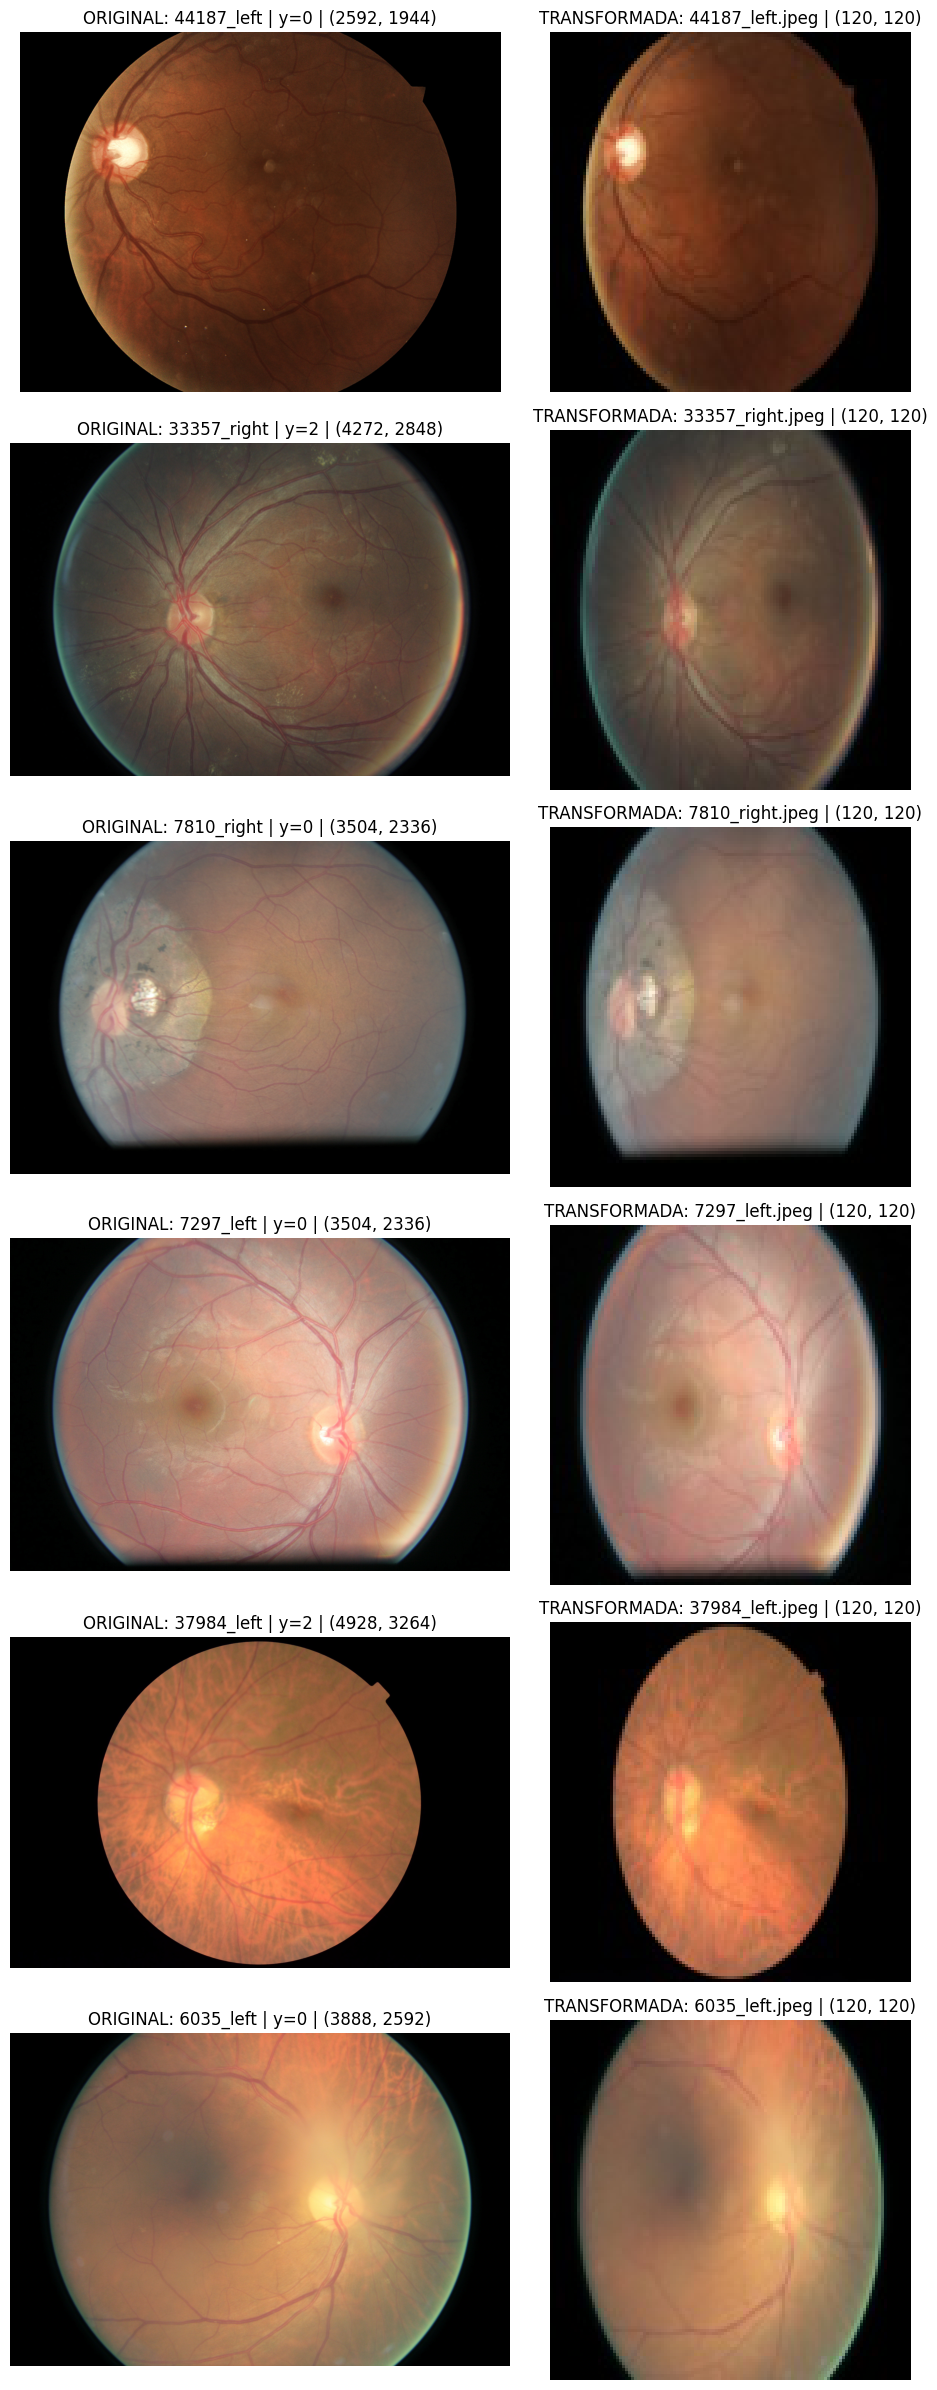

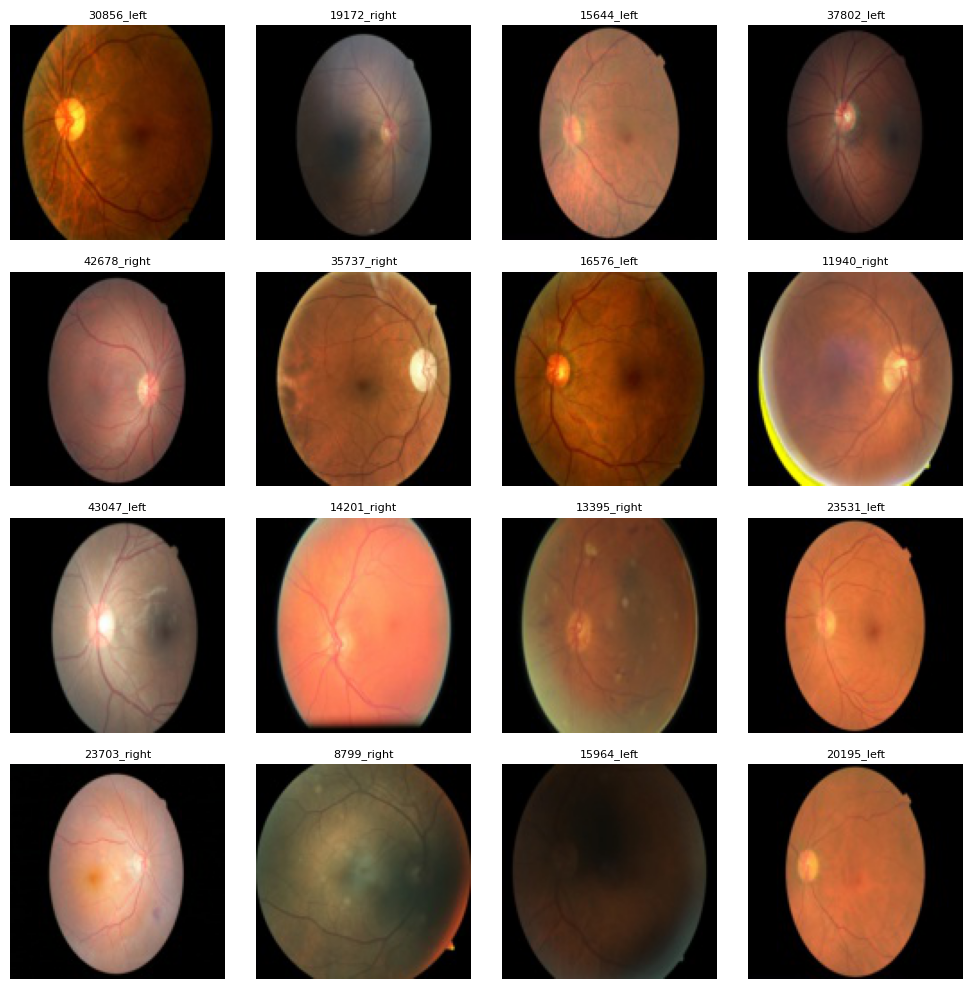

In [ ]:
# ============================================================
# 3) Validación visual: antes vs después + grilla transformadas
# ============================================================

ROOT = Path(r"C:\Proyecto final\diabetic-retinopathy-detection")
RAW_DIR = ROOT / "train"
OUT_DIR = ROOT / "dataset_120_square"
LABELS = OUT_DIR / "trainLabels.csv"   # el que generaste

df = pd.read_csv(LABELS)

def find_raw(stem_noext: str) -> Path:
    for ext in [".jpeg", ".jpg", ".png"]:
        p = RAW_DIR / f"{stem_noext}{ext}"
        if p.exists():
            return p
    raise FileNotFoundError(stem_noext)

# ---- 1) Antes vs Después (N ejemplos) ----
N = 6
idxs = random.sample(range(len(df)), k=min(N, len(df)))

fig, axs = plt.subplots(len(idxs), 2, figsize=(10, 4*len(idxs)))
if len(idxs) == 1:
    axs = [axs]

for r, idx in enumerate(idxs):
    stem = df.loc[idx, "image"]
    label = df.loc[idx, "level"] if "level" in df.columns else df.loc[idx, df.columns[1]]

    img_raw = Image.open(find_raw(stem)).convert("RGB")
    img_out = Image.open(OUT_DIR / f"{stem}.jpeg").convert("RGB")

    axs[r][0].imshow(img_raw)
    axs[r][0].set_title(f"ORIGINAL: {stem} | y={label} | {img_raw.size}")
    axs[r][0].axis("off")

    axs[r][1].imshow(img_out)
    axs[r][1].set_title(f"TRANSFORMADA: {stem}.jpeg | {img_out.size}")
    axs[r][1].axis("off")

plt.tight_layout()
plt.show()

# ---- 2) Grilla de SOLO transformadas (16 imágenes) ----
K = 16
idxs = random.sample(range(len(df)), k=min(K, len(df)))

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()

for i, idx in enumerate(idxs):
    stem = df.loc[idx, "image"]
    img = Image.open(OUT_DIR / f"{stem}.jpeg").convert("RGB")
    axs[i].imshow(img)
    axs[i].set_title(stem, fontsize=8)
    axs[i].axis("off")

plt.tight_layout()
plt.show()